In [163]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

from pyfusion.data import load

In [164]:
SLICE = 70
WINDOW_X = 45
WINDOW_Y = 105

KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001

ITERATIONS = 10_000
STEP_SIZE = 3

In [165]:
def gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Generate a Gaussian kernel.
    """
    return np.exp(-(x**2 + y**2) / (2 * std_dev**2)) / (2 * np.pi * std_dev**2)


def dx_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to x.
    """
    return -x * gaussian(std_dev, x, y) / (std_dev**2)


def dy_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to y.
    """
    return -y * gaussian(std_dev, x, y) / (std_dev**2)

def lambda_func(mu_1, mu_2):
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)

In [166]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [167]:
def show_vector_field(image: np.ndarray, vectors: np.ndarray):
    if image.shape[:2] != vectors.shape[:2] or vectors.shape[2] != 2:
        raise ValueError("Image and vector field must have shape (H, W) and (H, W, 2) respectively")

    H, W = image.shape[:2]
    Y, X = np.mgrid[0:H, 0:W]
    U = vectors[:, :, 0]
    V = vectors[:, :, 1]

    # Compute direction (angle) and map to color
    angles = np.arctan2(V, U)
    angles_normalized = (angles + np.pi) / (2 * np.pi)
    color_map = plt.cm.hsv(angles_normalized)  # shape: (H, W, 4)

    # Flatten everything to 1D
    Xf = X.flatten()
    Yf = Y.flatten()
    Uf = U.flatten()
    Vf = V.flatten()
    Cf = color_map.reshape(-1, 4)  # RGBA

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None, origin='upper')
    plt.quiver(Xf, Yf, Uf, Vf, color=Cf, angles='xy', scale_units='xy', scale=1.0)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

In [168]:
FSL = load.load_fsl("../data/example_mri", SLICE)

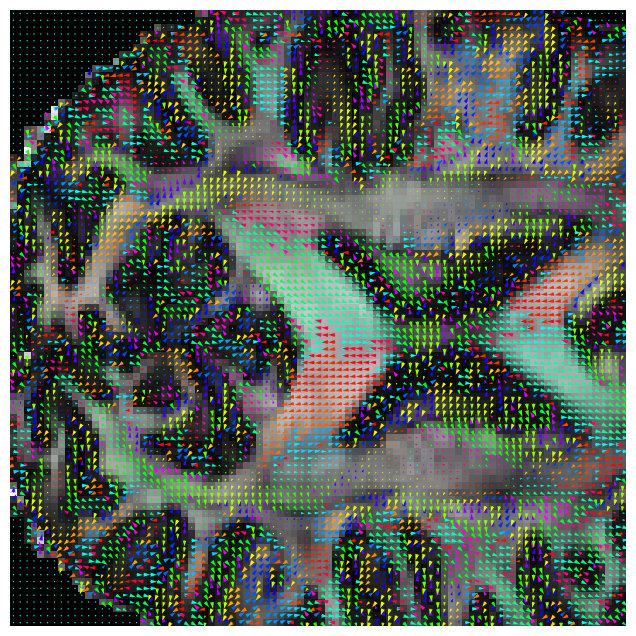

In [169]:
show_vector_field(FSL.FA[30: 120, 30: 120], FSL.V1[30: 120, 30: 120, :2])

In [170]:
# load the eigenvectors and eigenvalues
eigvec_1, eig_val_1 = FSL.V1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_2, eig_val_2 = FSL.V2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_3, eig_val_3 = FSL.V3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]

In [171]:
# generate a gray scale image with a circle in the center
image = np.zeros((WINDOW_Y - WINDOW_X, WINDOW_Y - WINDOW_X), dtype=np.float32)
Y, X = np.ogrid[:WINDOW_Y - WINDOW_X, :WINDOW_Y - WINDOW_X]
mask = (X - (WINDOW_Y - WINDOW_X) // 2)**2 + (Y - (WINDOW_Y - WINDOW_X) // 2)**2 <= ((WINDOW_Y - WINDOW_X) // 32)**2
image[mask] = 1.

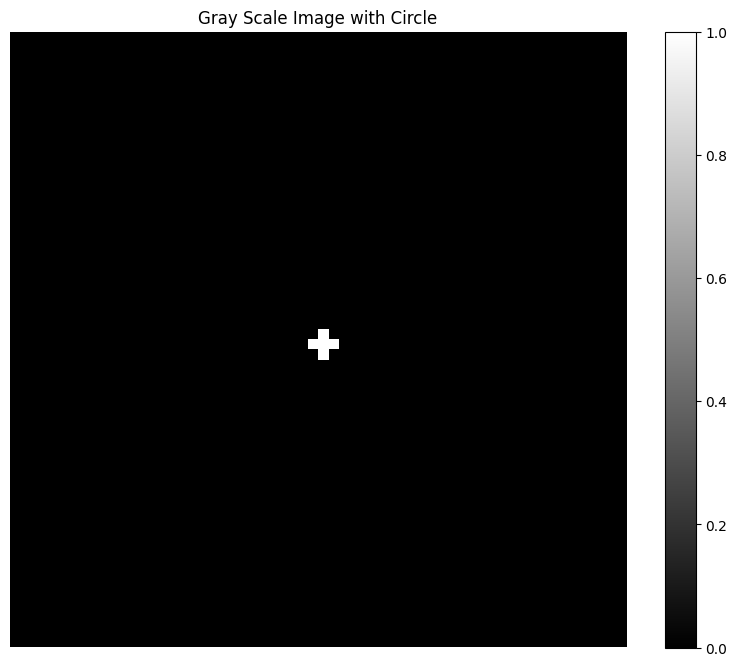

In [172]:
# plot the image
plot(image, "Gray Scale Image with Circle")

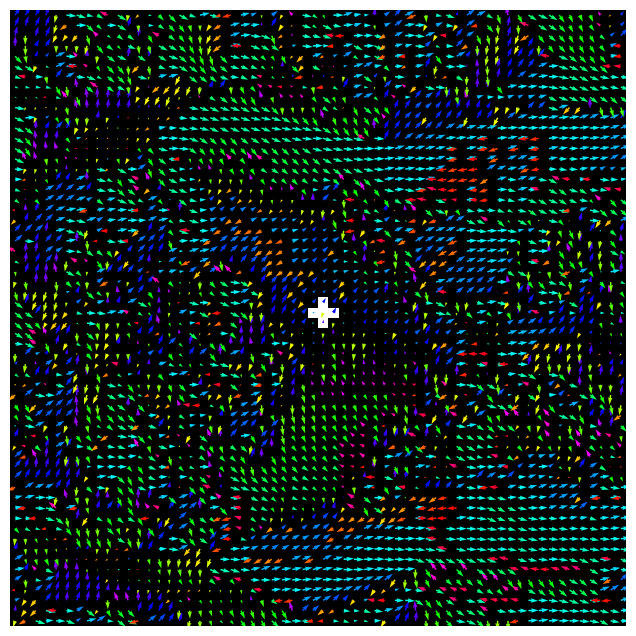

In [173]:
show_vector_field(image, eigvec_2[:, :, :2])

We assume that the eigenvector are orthonormal, becaouse they represent a symmetric positive definite matrix (diffusion tensor).

In [174]:
V = np.stack((eigvec_1, eigvec_2, eigvec_3), axis=-1)
Lambda = np.stack((eig_val_1, eig_val_2, eig_val_3), axis=-1)
V_scaled = V * Lambda[..., np.newaxis, :]
tensor_field = np.matmul(V_scaled, np.swapaxes(V, -1, -2))
tensor_field = tensor_field[..., :2, :2]

We define the diffusion tensor via
\begin{bmatrix}
a & b \\
b & c
\end{bmatrix}

In [175]:
a = tensor_field[..., 0, 0]
b = tensor_field[..., 0, 1]
c = tensor_field[..., 1, 1]

In [176]:
img = image.copy()

mu_1 = np.zeros(img.shape)
mu_2 = np.zeros(img.shape)
alpha_1 = np.zeros(img.shape)

discriminant = np.sqrt((a - c) ** 2 + 4 * (b**2))
v = np.stack((2 * b, c - a + discriminant), axis=-1)

alpha_1 = np.arctan2(v[..., 1], v[..., 0])
mu_1 = (a + c + discriminant) / 2
mu_2 = (a + c - discriminant) / 2

lambda_2 = ALPHA
lambda_1 = np.zeros_like(mu_2)

mask = np.isclose(mu_1, mu_2)
lambda_1[mask] = ALPHA
lambda_1[~mask] = lambda_func(mu_1[~mask], mu_2[~mask])

A = lambda_1 * np.cos(alpha_1)**2 + lambda_2 * np.sin(alpha_1)**2
B = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
C = lambda_1 * np.sin(alpha_1)**2 + lambda_2 * np.cos(alpha_1)**2

for _ in range(ITERATIONS):
    D_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])  / 32
    D_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

    j_1 = A * convolve2d(img, D_x, mode="same", boundary="symm") + B * convolve2d(img, D_y, mode="same", boundary="symm")
    j_2 = B * convolve2d(img, D_x, mode="same", boundary="symm") + C * convolve2d(img, D_y, mode="same", boundary="symm")

    delta = convolve2d(j_1, D_x, mode="same", boundary="symm") + convolve2d(j_2, D_y, mode="same", boundary="symm")

    img += STEP_SIZE * delta

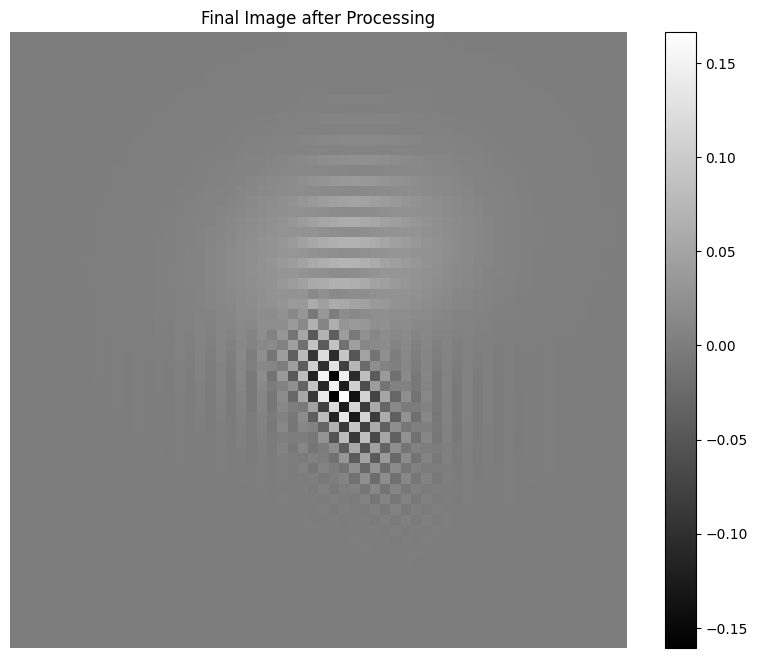

In [177]:
plot(img, title="Final Image after Processing")

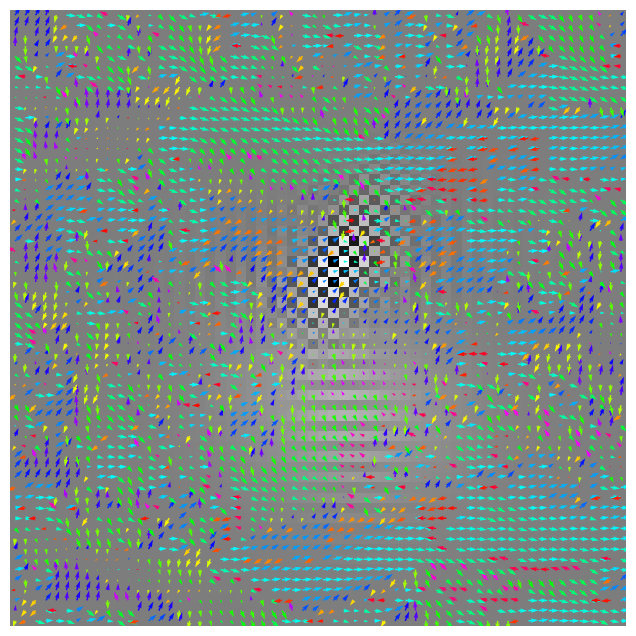

In [178]:
show_vector_field(img, eigvec_2[..., :2])

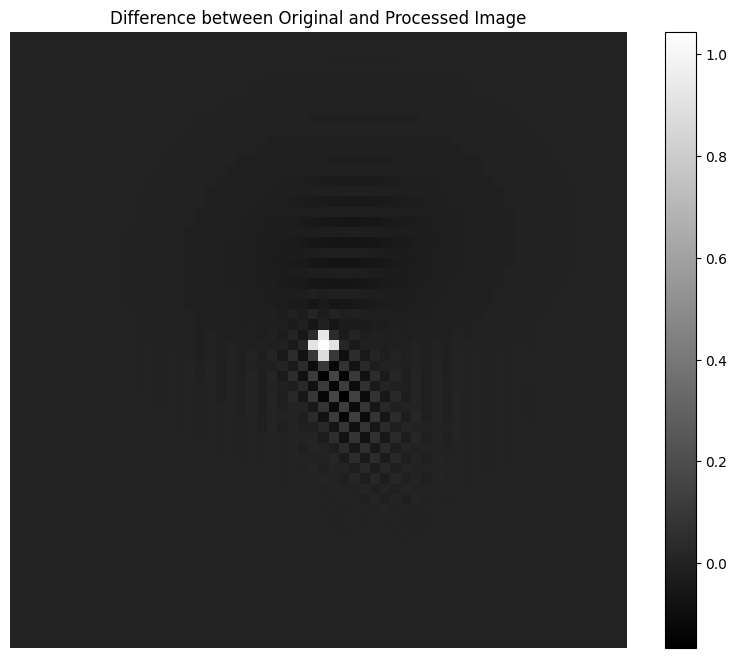

In [179]:
plot(image-img, title="Difference between Original and Processed Image")

In [180]:
# stats
np.std(image - img)

np.float32(0.038692493)